In [1028]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

color_lst = ['#059ff6', '#f22e92', '#7565df', '#8fd5fa', '#0c385b', '#a1c1ea']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_lst) 

from math import ceil

from scipy import stats
from statsmodels.stats import weightstats


In [463]:
experiment = pd.read_csv('../data/analytical_take_home_data_v3.csv')
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


In [464]:
# Data is collected from 15,474 advertisers with the experimentation randomly splitting advertisers 
# to test the new product
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


### Data Schema 

A/B Testing Result <br>
**Experiment**: pay each time ads appears in a user’s viewport rather than each time a user clicks on ads. (CTR vs Impressions)<br>

<br>


1) treatment 
- true = new product (pay on impressions)
- false = old product (pay on clicks)

2) company size
- small: local businesses 
- medium: small national brands
- large: global brands 

3) campaign spend & campaign budget: amount budgeted by the advertizers and spent by Twitter in the time of the experiment

In [465]:
# Overspend: the amount that Twitter has to cover for ad spend that exceeded the campaign's budget. 
# if spending remains within the budget, Twitter will not incur any additional overspend expense (hence, $0)
experiment['overspend_amt'] = experiment.campaign_spend - experiment.campaign_budget
experiment['overspend_amt'] = experiment.overspend_amt.clip(lower=0)
experiment['overspend'] = experiment.overspend_amt > 0 

In [466]:
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget,overspend_amt,overspend
0,False,small,10.4477,3.9035,6.5442,True
1,False,medium,3.7776,1.9872,1.7904,True
2,False,medium,46.1880,55.4523,0.0000,False
3,False,small,6.6271,6.5136,0.1135,True
4,False,small,92.3405,83.1018,9.2387,True


In [467]:
experiment_count = experiment.treatment.value_counts()
experiment_count

True     7741
False    7733
Name: treatment, dtype: int64

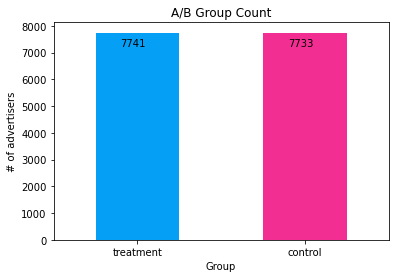

In [468]:
ax = experiment_count.plot(kind='bar', color=color_lst[:2], title='A/B Group Count',
                          xlabel='Group', ylabel='# of advertisers')

ax.set_xticklabels(['treatment', 'control'], rotation=0)


for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.15, p.get_height() - 500))

fig = ax.get_figure()
fig.savefig('../images/ab_count')

In [469]:
mapping_dict = {True:'treatment', False:'control'}

experiment_prop = experiment.treatment.value_counts(normalize=True).rename(index=mapping_dict)
experiment_prop

treatment    0.500258
control      0.499742
Name: treatment, dtype: float64

In [561]:
#  Medium category is very undersampled relative to the small ad company size category (most likely based 
# off of their abundance in the population).
company_size_prop = experiment.company_size.value_counts(normalize=True)
company_size_prop

small     0.575223
large     0.332558
medium    0.092219
Name: company_size, dtype: float64

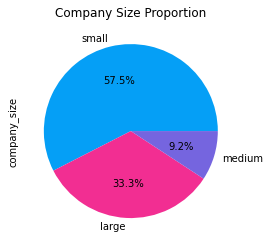

In [471]:
ax = company_size_prop.plot(kind='pie', autopct='%1.1f%%', title='Company Size Proportion')

fig = ax.get_figure()
fig.savefig('../images/company_size_pie');

In [472]:
company_size_prop_ab = pd.crosstab(experiment.company_size, experiment.treatment, colnames=['group'],
                                normalize='index')
company_size_prop_ab.rename(columns=mapping_dict, inplace=True)
company_size_prop_ab

group,control,treatment
company_size,,
large,0.524874,0.475126
medium,0.515067,0.484933
small,0.482755,0.517245


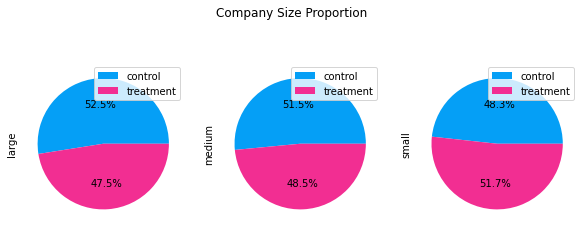

In [473]:
# there is a slight imbalance in the split between the treatment group and the control group, particularly 
# in the large company size category
ax = company_size_prop_ab.T.plot(kind='pie', autopct='%1.1f%%', title='Company Size Proportion', subplots=True, 
                           figsize=(10,4), labeldistance=None)


In [474]:
company_size_count_ab = pd.crosstab(experiment.company_size, experiment.treatment, colnames=['group'])
company_size_count_ab.rename(columns=mapping_dict, inplace=True)
company_size_count_ab

group,control,treatment
company_size,,
large,2701,2445
medium,735,692
small,4297,4604


''

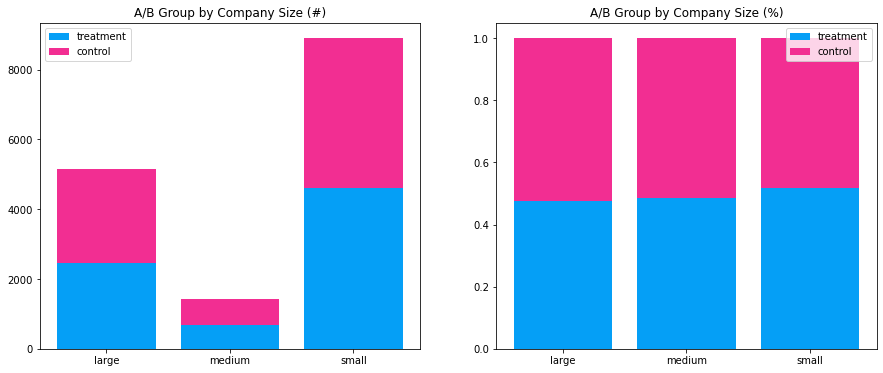

In [475]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

for idx, (df_summary, sign) in enumerate(zip([company_size_count_ab, company_size_prop_ab], ['#', '%'])):
    axs[idx].bar(df_summary.index, df_summary.treatment, label='treatment')
    axs[idx].bar(df_summary.index, df_summary.control, bottom=df_summary.treatment, 
           label='control')

    axs[idx].set_title(f'A/B Group by Company Size ({sign})')
    axs[idx].legend()
    

fig.savefig(f'../images/ab_by_company_size.jpg')

;


In [476]:
def plot_distribution(ab_df, col_name, title, separation_quantile):
    
#     print(f'The separation frequency is at ${df[col_name].quantile(separation_quantile):.1f}')
    fig, axs = plt.subplots(2, 2, figsize=(12,8), tight_layout=True)
    
    for idx, version in enumerate([True, False]):
        df = ab_df[ab_df.treatment == version]


        # create a new dataframe with the data below than the separation quantile of the given column 
        lower_bound_dist = df[col_name][(df[col_name] < df[col_name].quantile(separation_quantile))]

        # create another dataframe with the data higher than the separation quantile of the given column 
        upper_bound_dist = df[col_name][(df[col_name] >= df[col_name].quantile(separation_quantile))]


        


        # plot the lower bound distribution and median
        axs[0,idx].hist(lower_bound_dist, color=color_lst[idx]) 
        axs[0,idx].axvline(df[col_name].quantile(0.5), color='black', ls='--', 
                      label=f'median = {df[col_name].median():.1f}')

        axs[0,idx].set_ylabel('frequency')
        axs[0,idx].set_xlabel(col_name)
        axs[0,idx].set_title(f'{separation_quantile*100:.0f}% of the Data Distribution', fontsize=14)
        axs[0,idx].legend()

        # plot the upper bound distribution and mean    
        axs[1,idx].hist(upper_bound_dist, color=color_lst[idx])
        axs[1,idx].axvline(df[col_name].mean(), color='black', ls='--', 
                      label=f'mean = {df[col_name].mean():.1f}', alpha=0.5)

        axs[1,idx].set_ylabel('frequency')
        axs[1,idx].set_xlabel(col_name)
        axs[1,idx].set_title(f'{100-separation_quantile*100:.0f}% of the Tail Data Distributiion', fontsize=14)
        axs[1,idx].legend()
    
    fig.suptitle(title + ' Treatment vs Control Group', fontsize=14)
    
    fig.savefig(f'../images/{col_name}_distribution.jpg')
    ;


In [477]:
experiment.describe().apply(lambda d: d.apply('{0:.1f}'.format))

,campaign_spend,campaign_budget,overspend_amt
count,15474.0,15474.0,15474.0
mean,4903.0,5772.6,341.5
std,65166.9,99033.8,4079.1
min,0.4,0.1,0.0
25%,15.2,12.8,0.1
50%,50.1,48.8,2.2
75%,236.5,252.3,7.8
max,5289216.9,10242888.2,288590.2


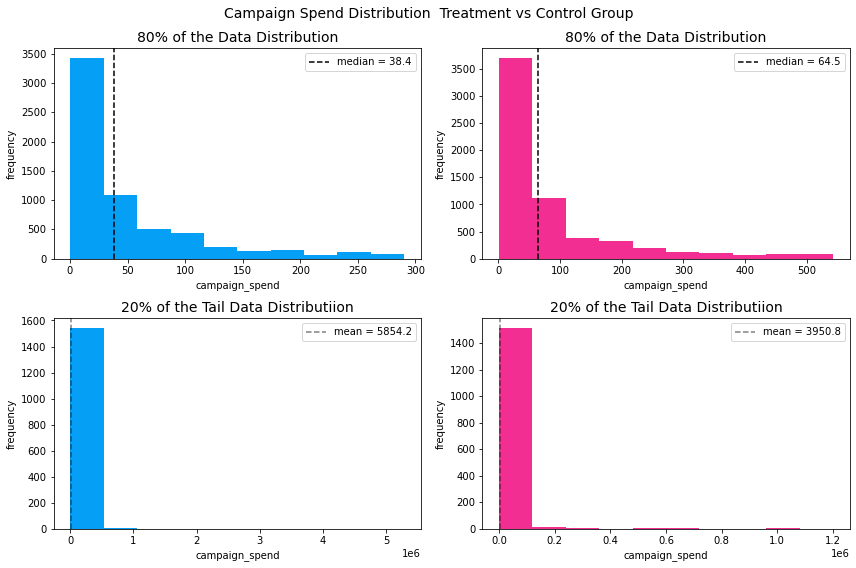

In [478]:
plot_distribution(experiment, 'campaign_spend', title='Campaign Spend Distribution ',
                  separation_quantile=0.8)

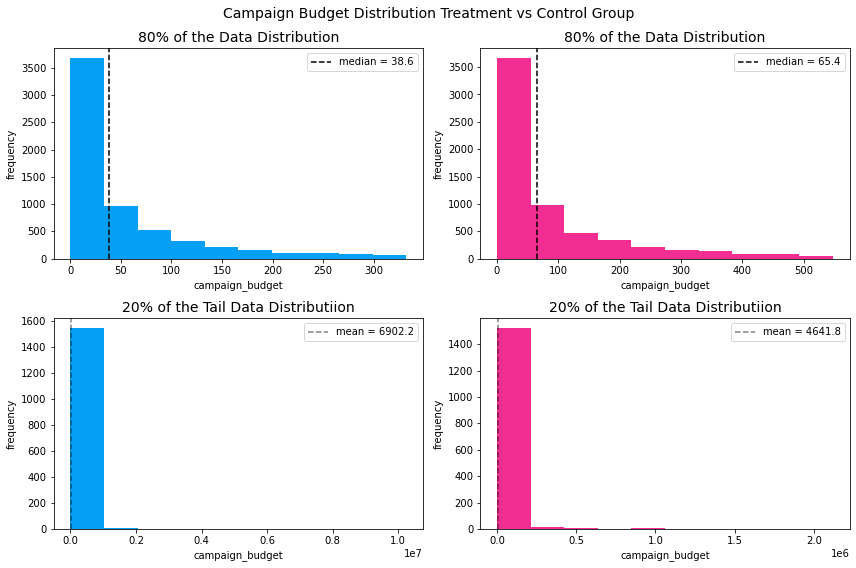

In [479]:
plot_distribution(experiment, 'campaign_budget', title='Campaign Budget Distribution', separation_quantile=0.8)

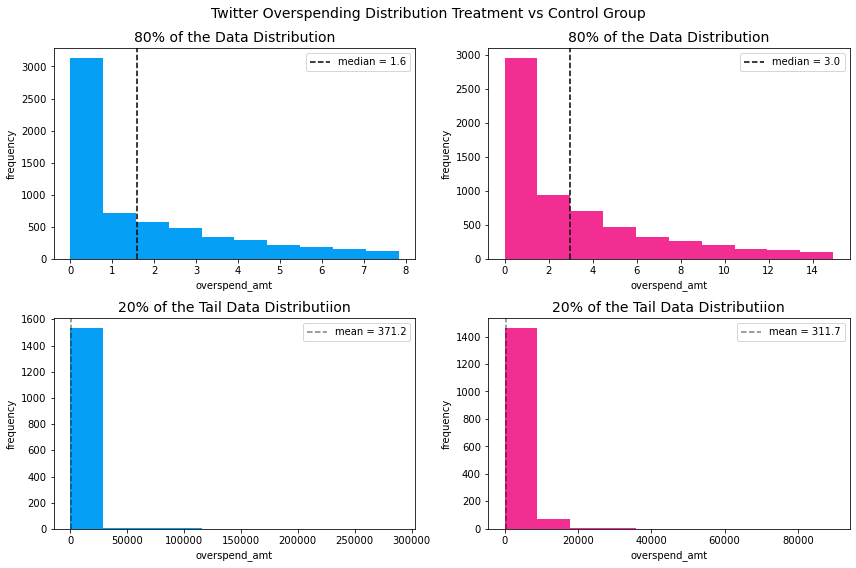

In [480]:
plot_distribution(experiment, 'overspend_amt', title='Twitter Overspending Distribution', separation_quantile=0.8)

In [484]:
experiment['overbudget_pct'] = experiment.overspend_amt / experiment.campaign_budget * 100

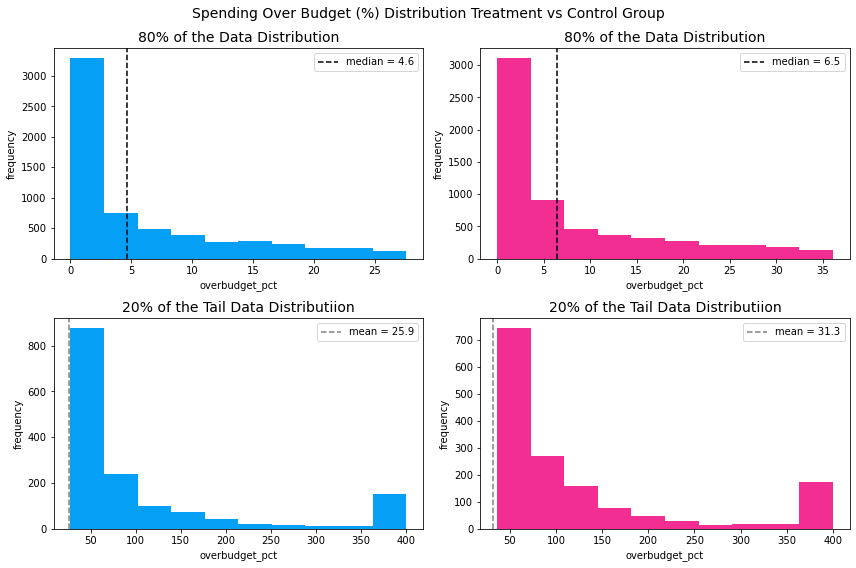

In [511]:
plot_distribution(experiment, 'overbudget_pct', title='Spending Over Budget (%) Distribution', 
                  separation_quantile=0.8)

In [485]:
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget,overspend_amt,overspend,overbudget_pct
0,False,small,10.4477,3.9035,6.5442,True,167.649545
1,False,medium,3.7776,1.9872,1.7904,True,90.096618
2,False,medium,46.1880,55.4523,0.0000,False,0.000000
3,False,small,6.6271,6.5136,0.1135,True,1.742508
4,False,small,92.3405,83.1018,9.2387,True,11.117328


In [486]:
experiment.groupby('treatment').agg(
    count = ('overspend', 'count'),
    overspend_count = ('overspend', 'sum'),
    overspend_proportion = ('overspend', 'mean')).rename(index=mapping_dict)

,count,overspend_count,overspend_proportion
treatment,,,
control,7733,6257,0.809130
treatment,7741,5721,0.739052


In [488]:
experiment.groupby('treatment').agg(
    overspend_count = ('overspend', 'sum'),
    avg_overbudget_pct = ('overbudget_pct', 'mean')).rename(index=mapping_dict)

,overspend_count,avg_overbudget_pct
treatment,,
control,6257,31.323029
treatment,5721,25.933369


## Part 2. Q1. No of Campaigns with ≥ 1% Overbudget

In [490]:
overpend_greater_1pct = experiment[(experiment.overbudget_pct > 1)].groupby('treatment').agg(
                            gt_1pct_overbudget_count = ('overspend', 'count'),
                            avg_overspend_pct = ('overbudget_pct', 'mean'))

overpend_greater_1pct = overpend_greater_1pct.rename(index=mapping_dict)

overpend_greater_1pct

,gt_1pct_overbudget_count,avg_overspend_pct
treatment,,
control,5716,42.330107
treatment,5180,38.705676


In [491]:
overpend_greater_1pct_by_companysize = experiment[(experiment.overbudget_pct > 1)].groupby(
                                            ['treatment', 'company_size']).agg(
                                            gt_1pct_overbudget_count = ('overspend', 'count'),
                                            avg_overbudget_pct = ('overbudget_pct', 'mean'),
                                            avg_overspend_amt = ('overspend_amt', 'mean'),
                                            total_overspend_amt = ('overspend_amt', 'sum')
                                            )

overpend_greater_1pct_by_companysize = overpend_greater_1pct_by_companysize.apply(
                        lambda d: d.apply('{0:.0f}'.format)).rename(index=mapping_dict)

overpend_greater_1pct_by_companysize

gt_1pct_overbudget_count avg_overbudget_pct  \
treatment company_size                                               
control   large                            1875                 28   
          medium                            452                 21   
          small                            3389                 53   
treatment large                            1504                 21   
          medium                            414                 25   
          small                            3262                 49   

                       avg_overspend_amt total_overspend_amt  
treatment company_size                                        
control   large                      781             1463808  
          medium                     224              101323  
          small                      247              837792  
treatment large                      704             1059051  
          medium                     389              161186  
          small                      497             1620581

## Part 2. Q2. Effectiveness of New Product

In [514]:
experiment.head(2)

,treatment,company_size,campaign_spend,campaign_budget,overspend_amt,overspend,overbudget_pct
0,False,small,10.4477,3.9035,6.5442,True,167.649545
1,False,medium,3.7776,1.9872,1.7904,True,90.096618


In [534]:
# shows the number of advertisers that fell into each variant, with 7733 in control and 7741 in treatment
# as we recall above, with a ratio of 49.97% and 50.02% respectively. 
experiment_count.rename(index=mapping_dict)

treatment    7741
control      7733
Name: treatment, dtype: int64

In [604]:
sample_size = ceil(experiment.shape[0]/2)
sample_size

7737

We will do a Chi-Square Goodness of Fit Test to decide if Decide if one variable is likely to come from a given distribution or not. 

$H_o$: proportion of treatment groups are the same <br>

$H_a$: proportions of treatment groups are not the same

With alpha set at 0.1% and degrees of freedom at 1 (no of categories - 1), therfore delta degrees of freedom as 0

In [648]:
stats.chisquare(f_obs=experiment_count.values, f_exp=[sample_size, sample_size], ddof=0)

Power_divergenceResult(statistic=0.004135970014217397, pvalue=0.9487221906574269)

The one-way chi-square test tests for Sample Ratio Mismatch. Since the p value is 0.95, we fail to reject the null hypothesis and conclude **no evidence of SRM**. In other words, treatment assignment works as expected.


In [547]:
experiment.groupby('treatment')[['overspend_amt']].mean().rename(index=mapping_dict)


,overspend_amt
treatment,
control,311.744962
treatment,371.204552


In [548]:
experiment.groupby('treatment')[['campaign_budget']].mean().rename(index=mapping_dict)


,campaign_budget
treatment,
control,4641.827622
treatment,6902.232566


In [549]:
experiment.groupby('treatment')[['overbudget_pct']].mean().rename(index=mapping_dict)

,overbudget_pct
treatment,
control,31.323029
treatment,25.933369


### Some questions that surfaces are:

1. Treatment has a lower over budget spend ratio (0.26) than the control (0.31). Is the difference significant?
2. To what extent can we trust the result?
3. What is the variability of the difference?
4. How many times do we obtain more extreme values, if we repeat the process for large number of times? 

In [1154]:
def generate_stratified_boootstrap_sample_stats(
    df,
    col_to_evaluate,
    sample_size=7737,
    strata_proportions=[1/3, 1/3, 1/3],
    n_bootstrap_samples=10000):
    
    bootstrap_sample_stats = []
    
    
    small_df = df.company_size[df.company_size == 'small']
    medium_df = df.company_size[df.company_size == 'medium']
    large_df = df.company_size[df.company_size == 'large']

    
    for i in range(n_bootstrap_samples):
        stratified_idx = list(small_df.sample(int(sample_size*strata_proportions[0]), replace=True).index) \
                 + list(medium_df.sample(int(sample_size*strata_proportions[1]), replace=True).index) \
                 + list(large_df.sample(int(sample_size*strata_proportions[2]), replace=True).index) 
    
        
        stratified_bootstrap_sample = df.loc[stratified_idx,:]
        
        control_result = stratified_bootstrap_sample[stratified_bootstrap_sample.treatment == False]
        treatment_result = stratified_bootstrap_sample[stratified_bootstrap_sample.treatment == True]
        t_stat, p_val = stats.ttest_ind(control_result[col_to_evaluate], treatment_result[col_to_evaluate])
        
        bootstrap_result = {'control': control_result[col_to_evaluate].mean(),
                           'treatment': treatment_result[col_to_evaluate].mean(),
                           't_stat': t_stat,
                           'p_val': p_val}
        
        bootstrap_sample_stats.append(bootstrap_result)

        
    return pd.DataFrame(bootstrap_sample_stats)




In [1220]:
bootstrap_stats = generate_stratified_boootstrap_sample_stats(
    experiment, 'overbudget_pct', sample_size, [1/3, 1/3, 1/3], 100)

In [1221]:
bootstrap_stats.head()

,control,treatment,t_stat,p_val
0,24.082220,20.942912,3.356985,0.000790
1,23.692357,22.744991,1.009256,0.312868
2,24.582881,21.339606,3.439145,0.000585
3,24.829119,21.447740,3.601461,0.000317
4,23.396754,20.702705,2.939223,0.003295


In [1218]:
(bootstrap_stats.treatment - bootstrap_stats.control )/ bootstrap_stats.control * 100

0     46.501335
1      0.428949
2      0.252140
3     31.114590
4     11.115265
        ...    
95    -0.786684
96    58.083497
97    18.913524
98   -24.677895
99    50.243047
Length: 100, dtype: float64

In [1199]:
1 - 0.76

0.24

In [1285]:
def generate_stratified_boootstrap_sample_stats(
    df, 
    col_to_evaluate,  
    n_bootstrap_samples=10000,
    level=0, 
    **kwargs): 
    
    '''
    Documentation 
    '''
    
    bootstrap_sample_stats = []
    
    if level == 0:
        strata_proportions = kwargs['strata_proportions']
        sample_size = kwargs['sample_size']
        
        small_df = df.company_size[df.company_size == 'small']
        medium_df = df.company_size[df.company_size == 'medium']
        large_df = df.company_size[df.company_size == 'large']
        
    elif level == 1:
        company_size = kwargs['company_size']
        sub_df = df.company_size[df.company_size == company_size]
        size = df.groupby('company_size')['company_size'].agg('count')[company_size]
    

    
    for i in range(n_bootstrap_samples):
        if level == 0:
            stratified_idx = list(small_df.sample(int(sample_size*strata_proportions[0])*2, replace=True).index) \
                     + list(medium_df.sample(int(sample_size*strata_proportions[1])*2, replace=True).index) \
                     + list(large_df.sample(int(sample_size*strata_proportions[2])*2, replace=True).index)

        elif level == 1:
            stratified_idx = list(sub_df.sample(int(size), replace=True).index)
        
        stratified_bootstrap_sample = df.loc[stratified_idx,:]
        
        control_result = stratified_bootstrap_sample[stratified_bootstrap_sample.treatment == False]
        treatment_result = stratified_bootstrap_sample[stratified_bootstrap_sample.treatment == True]
        t_stat, p_val = stats.ttest_ind(control_result[col_to_evaluate], treatment_result[col_to_evaluate])
        
        bootstrap_result = {'control': control_result[col_to_evaluate].mean(),
                           'treatment': treatment_result[col_to_evaluate].mean(),
                           't_stat': t_stat,
                           'p_val': p_val}
        
        bootstrap_sample_stats.append(bootstrap_result)

        
    return pd.DataFrame(bootstrap_sample_stats)




In [1299]:
def plot_hist_dist(
    df, 
    col_to_evaluate,  
    n_bootstrap_samples=10000,
    level=0, 
    **kwargs):
    
    bootstrap_stats = generate_stratified_boootstrap_sample_stats(
        df, col_to_evaluate, n_bootstrap_samples, level, **kwargs)
    
    
    fig, axs = plt.subplots(1, 3, figsize=(20,4))
    
    bootstrap_stats[['treatment', 'control']].plot(kind = 'kde', ax=axs[0])
    
    col_name = ' '.join(col_to_evaluate.split('_'))
    axs[0].set_xlabel(col_name)
    
    
    bootstrap_stats['diff'] = (bootstrap_stats.treatment - bootstrap_stats.control)\
                                 /bootstrap_stats.control * 100 

    
    bootstrap_stats['diff'].plot(kind = 'kde', ax=axs[1], color=color_lst[3])
    
    axs[1].set_xlabel('% diff in means')
    
    bootstrap_stats['p_val'].plot(kind = 'kde', ax=axs[2], color=color_lst[4])
    axs[2].set_xlabel('p-values')
    
    
    p = (bootstrap_stats['diff'] > 0).sum()/ len(bootstrap_stats)
    print(f'Treatment has a better performance than the control on {col_name} {p*100:.2f}% of the time.')
    
    

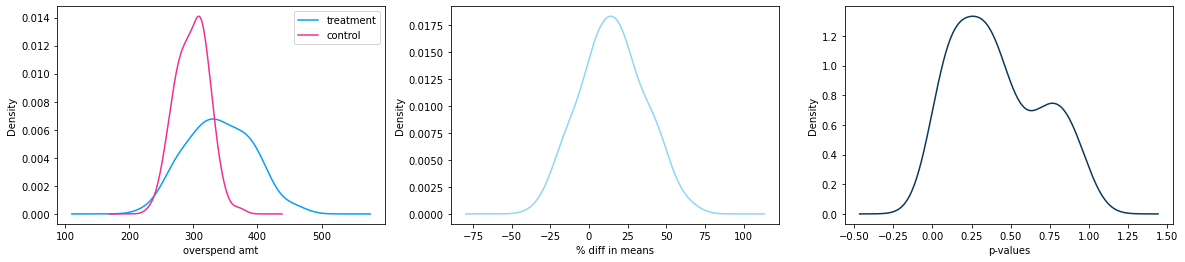

In [1296]:
plot_hist_dist(experiment, 'overspend_amt', 100, 0, sample_size=sample_size, strata_proportions=[1/3, 1/3, 1/3])

Treatment has a better performance than the control on overbudget pct 100.00% of the time.


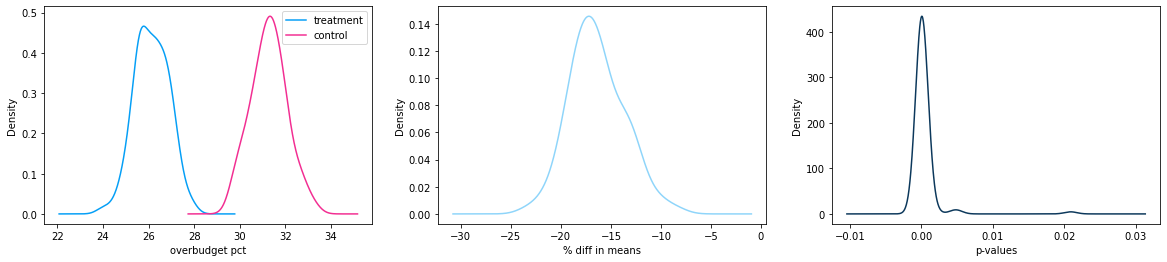

In [1270]:
plot_hist_dist(experiment, 'overbudget_pct', 100, 0, sample_size=sample_size, strata_proportions=[1/3, 1/3, 1/3])

Treatment has a better performance than the control on overspend amt 0.00% of the time.


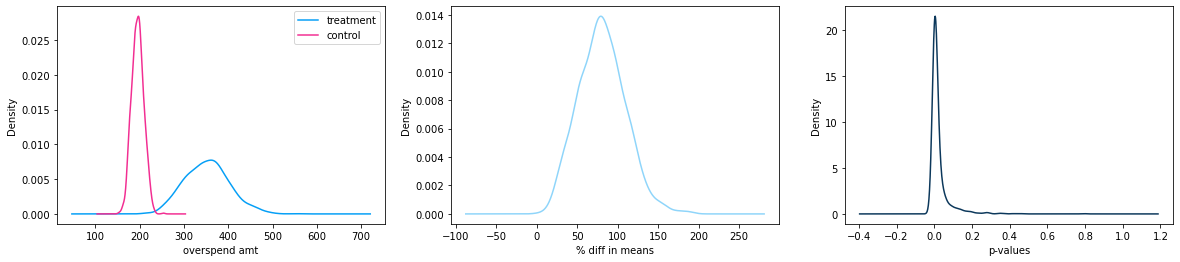

In [1265]:
plot_hist_dist(experiment, 'overspend_amt', 1000, 1, company_size='small')

Treatment has a better performance than the control on overspend amt 0.20% of the time.


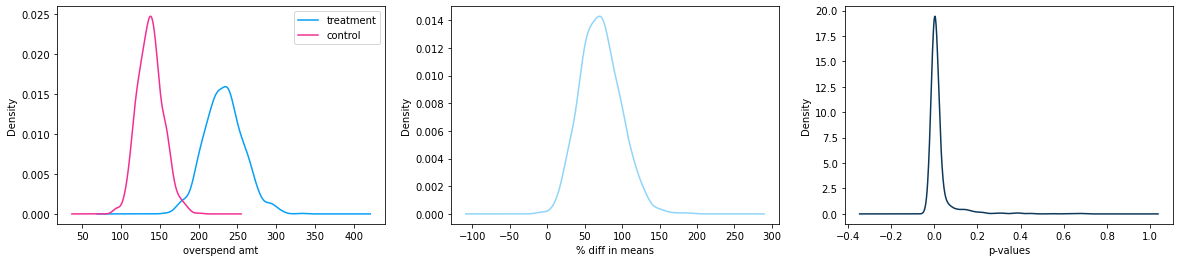

In [1266]:
plot_hist_dist(experiment, 'overspend_amt', 1000, 1, company_size='medium')

Treatment has a better performance than the control on overspend amt 87.40% of the time.


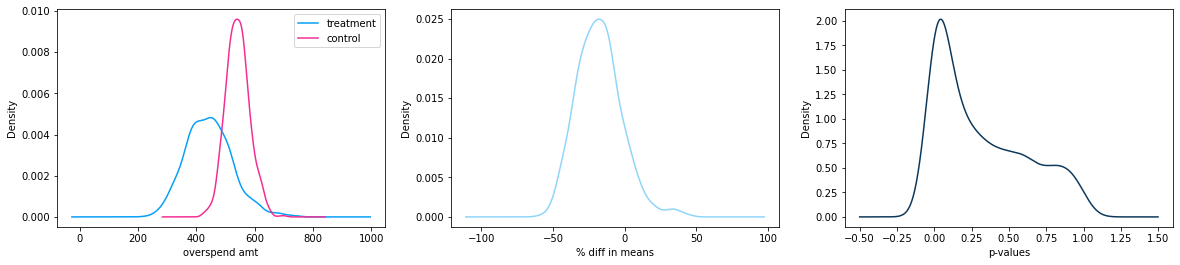

In [1267]:
plot_hist_dist(experiment, 'overspend_amt', 1000, 1, company_size='large')

Treatment has a better performance than the control on campaign budget 95.40% of the time.


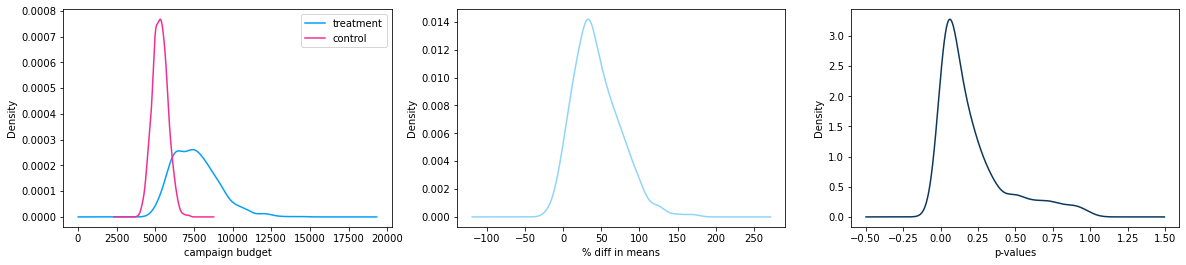

In [1300]:
plot_hist_dist(experiment, 'campaign_budget', 1000, 0, sample_size=sample_size, strata_proportions=[1/3, 1/3, 1/3])